# <center>Frozen Dessert Sales Prediction</center>

### Import libraries

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import warnings

warnings.filter_warnings('ignore')
%matplotlib inline

AttributeError: module 'warnings' has no attribute 'filter_warnings'

### Initialize Dataframe

In [2]:
df = pd.read_csv('sales.csv', index_col='DATE', parse_dates=True)
df.head(15)

,IPN31152S
DATE,
1972-01-01,79.9216
1972-02-01,75.5734
1972-03-01,75.4050
1972-04-01,76.8361
1972-05-01,77.7640
1972-06-01,76.8775
1972-07-01,79.2009
1972-08-01,79.9047
1972-09-01,79.7728


In [3]:
df.rename(columns={'IPN31152S': 'Sales'}, inplace=True)

### Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 625 entries, 1972-01-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   625 non-null    float64
dtypes: float64(1)
memory usage: 9.8 KB


In [5]:
df.describe()

,Sales
count,625.000000
mean,110.271798
std,19.883061
min,75.405000
25%,96.003900
50%,109.348900
75%,122.830600
max,163.133800


In [6]:
df.isnull().sum()

Sales    0
dtype: int64

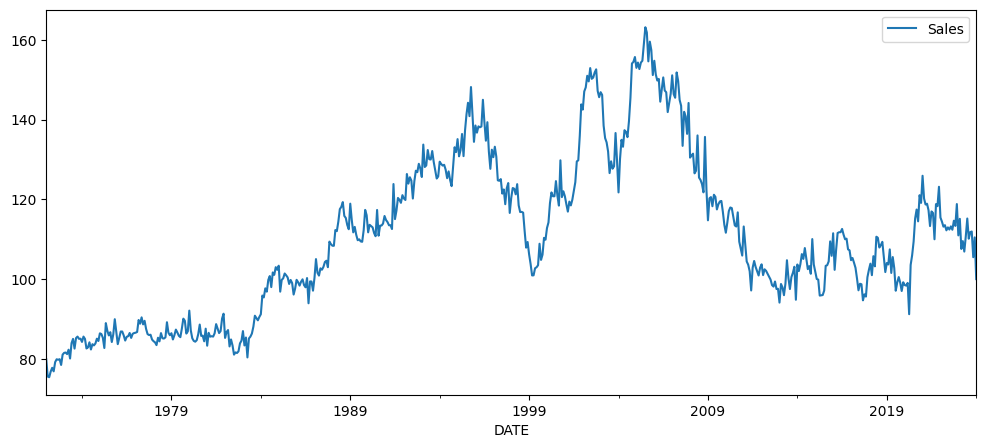

In [7]:
df.plot(figsize=(12, 5))
plt.show()

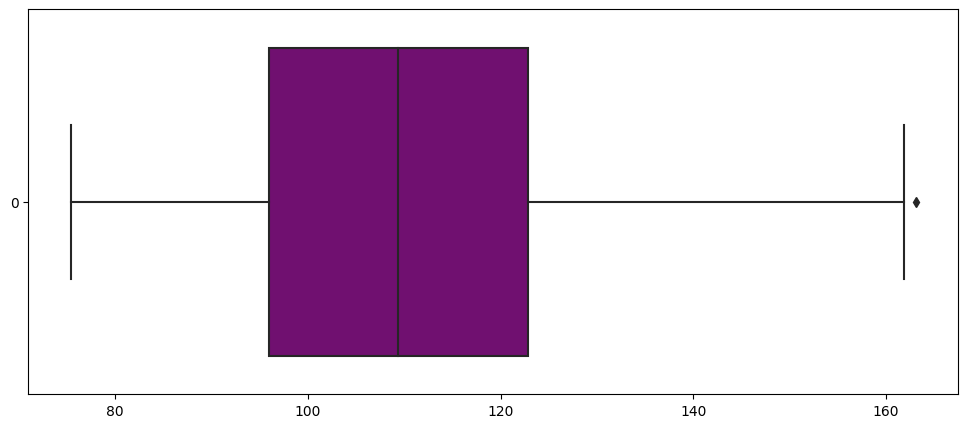

In [8]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=df['Sales'], orient='h', color='purple')
plt.show()

In [9]:
df['Sales'].max(), df['Sales'].min()

(163.1338, 75.405)

In [10]:
df[df.Sales == 163.1338], df[df.Sales == 75.405]

(               Sales
 DATE                
 2005-07-01  163.1338,
              Sales
 DATE              
 1972-03-01  75.405)

### Data Preprocessing

In [153]:
test_size = 18
test_ind = len(df) - test_size

In [154]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [155]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [156]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [157]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train,
                               length=length, batch_size=1)

### Training the model

In [196]:
n_features = 1

model = Sequential()
model.add(LSTM(150, input_shape=(length, n_features)))
model.add(Dense(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [197]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 150)               91200     
                                                                 
 dense_39 (Dense)            (None, 50)                7550      
                                                                 
 dense_40 (Dense)            (None, 1)                 51        
                                                                 
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


In [198]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
val_gen = TimeseriesGenerator(scaled_test, scaled_test,
                             length=length, batch_size=1)
model.fit(generator, epochs=20, validation_data=val_gen,
         callbacks=[early_stop])

Epoch 1/20
595/595 [==============================] - 9s 9ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 2/20
595/595 [==============================] - 5s 8ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 3/20
595/595 [==============================] - 6s 10ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 4/20
595/595 [==============================] - 6s 10ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 5/20
595/595 [==============================] - 6s 11ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 6/20
595/595 [==============================] - 6s 10ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 7/20
595/595 [==============================] - 6s 10ms/step - loss: 0.0022 - val_loss: 0.0023


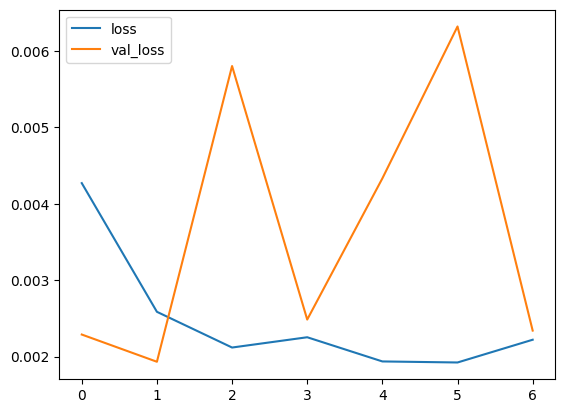

In [199]:
history = pd.DataFrame(model.history.history)
history.plot()
plt.show()

In [200]:
test_pred = []

eval_batch = scaled_train[-length:]
curr_batch = eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    curr_pred = model.predict(curr_batch, verbose=False)[0]
    test_pred.append(curr_pred)
    curr_batch = np.append(curr_batch[:, 1:, :], [[curr_pred]], axis=1)

In [201]:
true_pred = scaler.inverse_transform(test_pred)
test['Predictions'] = true_pred
test.head()

C:\Users\samra\AppData\Local\Temp\ipykernel_4988\3729521578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_pred


,Sales,Predictions
DATE,,
2022-08-01,113.2140,110.490154
2022-09-01,112.3706,109.288436
2022-10-01,114.6394,108.109004
2022-11-01,113.3256,106.954839
2022-12-01,118.8092,105.876093


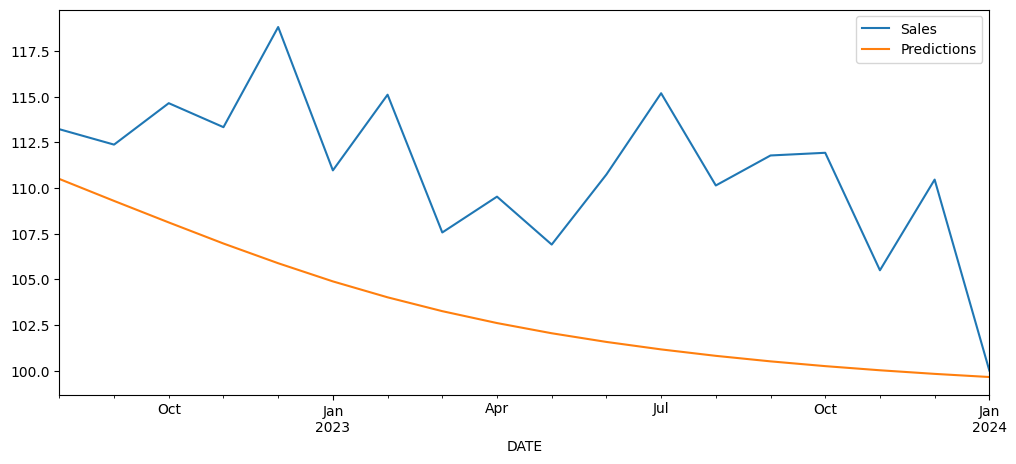

In [202]:
test.plot(figsize=(12, 5))
plt.show()

### Forecasting

In [203]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [204]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                length=length, batch_size=1)

In [205]:
n_features = 1

model = Sequential()
model.add(LSTM(150, input_shape=(length, n_features)))
model.add(Dense(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [206]:
model.fit(generator, epochs=6)

Epoch 1/6
613/613 [==============================] - 10s 10ms/step - loss: 0.0039
Epoch 2/6
613/613 [==============================] - 6s 10ms/step - loss: 0.0024
Epoch 3/6
613/613 [==============================] - 6s 10ms/step - loss: 0.0020
Epoch 4/6
613/613 [==============================] - 6s 10ms/step - loss: 0.0023
Epoch 5/6
613/613 [==============================] - 6s 9ms/step - loss: 0.0021
Epoch 6/6
613/613 [==============================] - 6s 10ms/step - loss: 0.0020


In [207]:
forecast = []
periods = 12

eval_batch = scaled_full_data[-length:]
curr_batch = eval_batch.reshape((1, length, n_features))

for i in range(periods):
    curr_pred = model.predict(curr_batch, verbose=False)[0]
    forecast.append(curr_pred)
    curr_batch = np.append(curr_batch[:, 1:, :], [[curr_pred]], axis=1)

In [208]:
forecast = full_scaler.inverse_transform(forecast)

In [209]:
df.tail()

,Sales
DATE,
2023-09-01,111.7763
2023-10-01,111.9233
2023-11-01,105.4900
2023-12-01,110.4558
2024-01-01,100.0007


In [210]:
forecast_ind = pd.date_range(start='2024-02-01', periods=periods,
                            freq='MS')

In [211]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_ind, columns=['Forecast'])

<Axes: xlabel='DATE'>

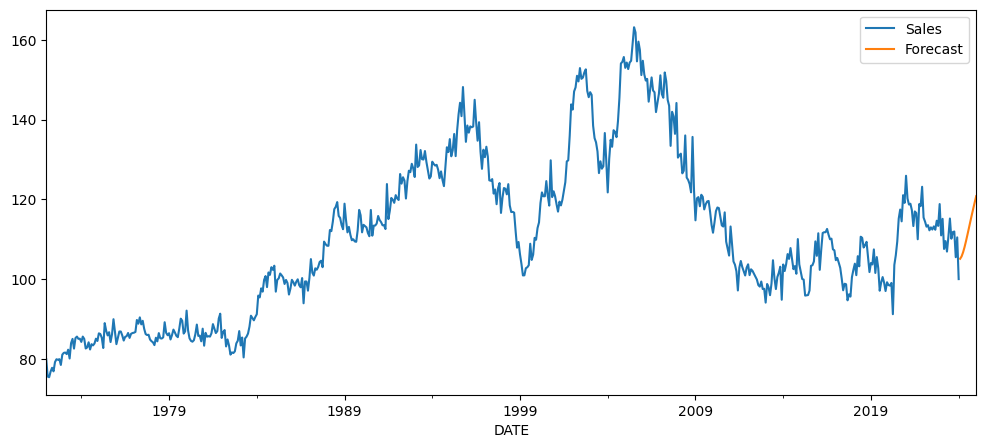

In [212]:
ax = df.plot(figsize=(12, 5))
forecast_df.plot(ax=ax)

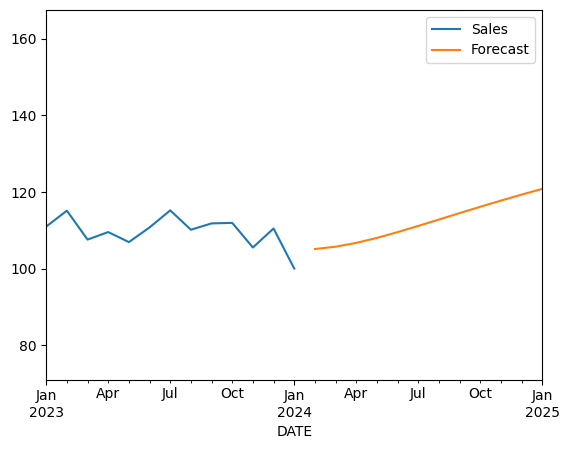

In [214]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2023-01-01', '2025-01-01')
plt.show()